In [ ]:
import os
import sys
sys.path.append(os.pardir)

In [ ]:
import json
import datetime
import pandas as pd
from sklearn import preprocessing
from credible import connectors, queries

In [ ]:
engine = connectors.connect_to_sqlite()

## Inputs

In [ ]:
%%time
users = queries.get_clean_users(engine)
reviews = queries.get_clean_reviews(engine)
users.shape, reviews.shape

In [5]:
users.sample(2)

,_id,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,...,user_id,user_id,date,num_of_reviews,times,business_ids,review_ids,count_business,user_id,perc_of_positive
102344,897999,TRRjaMgEc2faZEzIGx2dPw,Aaron,8,2012-05-14 20:39:50,j7IxR_ZZZ06jZP_FWz06CQ,4,0,0,1,...,TRRjaMgEc2faZEzIGx2dPw,None,None,None,None,None,None,None,None,NaN
73733,616508,IpoXMWXjeqAqjnjOUGAFcQ,S,8,2011-06-09 23:32:49,None,9,1,4,1,...,IpoXMWXjeqAqjnjOUGAFcQ,None,None,None,None,None,None,None,None,NaN


In [6]:
reviews.sample(2)

,_id,review_id,business_id,user_id,stars,date,text,useful,funny,cool,...,sentiment_subjectivity,ratio_content,ratio_lexical,avg_len_sentences,avg_len_words,count_noun_phrases,count_words,count_sentences,count_pos,noun_phrases
742969,3989565,-qZ-p2iT84iiwy0_C8IT-g,TtqvXhjmXXd0nhibRAbpRg,n7fUVjiw-cFNJCAQ0IqRaw,3,2018-04-26 01:52:28,I asked for miso soup and they forgot about it...,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
451323,2411935,3RkNQNK_BLmmrRHbUb5Gfg,dRva9yUGTgZBEp9gbSxjIg,jDJQpzb_EIelD-LbYNlWkQ,5,2015-03-29 01:18:18,Just stopped by today and received a great hai...,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


## EDA

### EDA - Daily Review Counts

In [134]:
df = pd.merge(reviews, users.iloc[:,[1,3]], how='left', on='user_id')
df.shape

(1245408, 25)

In [135]:
df.review_count = df.review_count.apply(lambda x: float(x))
df.shape

(1245408, 25)

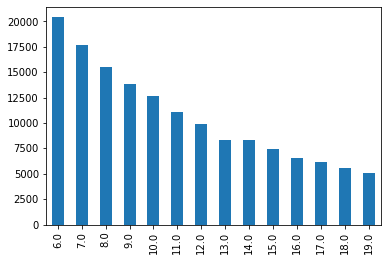

In [136]:
df.review_count.value_counts().plot.bar()

In [137]:
df_g_rc = df.groupby(by=['review_count']).mean()
df_g_rc.sort_index(axis=0, inplace=True, ascending=True)
df_g_rc.sample(2)

,_id,stars,useful,funny,cool,_id,sentiment_polarity,sentiment_subjectivity,ratio_content,ratio_lexical,avg_len_sentences,avg_len_words,count_noun_phrases,count_words,count_sentences
review_count,,,,,,,,,,,,,,,
15.0,3.293556e+06,4.174665,0.333646,0.093566,0.128686,59829.090226,0.361416,0.588215,1.0,0.910442,10.517275,4.361553,3.293233,26.496241,3.240602
12.0,3.343100e+06,4.229194,0.318804,0.085859,0.117182,55570.130137,0.323322,0.616064,1.0,0.906975,10.379452,4.366615,3.178082,26.561644,3.280822


In [121]:
import matplotlib.pyplot as plt

def get_review_plots(df_g_rc):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,5))

    df_g_rc.sentiment_polarity.plot(ax=axes[0,0], title='sentiment_polarity')
    df_g_rc.sentiment_subjectivity.plot(ax=axes[0,1], title='sentiment_subjectivity')
    df_g_rc.ratio_content.plot(ax=axes[0,2], title='ratio_content')
    df_g_rc.ratio_lexical.plot(ax=axes[0,3], kind='box', title='ratio_lexical')
    df_g_rc.avg_len_sentences.plot(ax=axes[1,0], kind='kde', title='avg_len_sentences')
    df_g_rc.avg_len_words.plot(ax=axes[1,1], kind='kde', title='avg_len_words')
    df_g_rc.count_noun_phrases.plot(ax=axes[1,2], kind='hist', title='count_noun_phrases')
    df_g_rc.count_sentences.plot(ax=axes[1,3], kind='hist', title='count_sentences')

    fig.tight_layout()

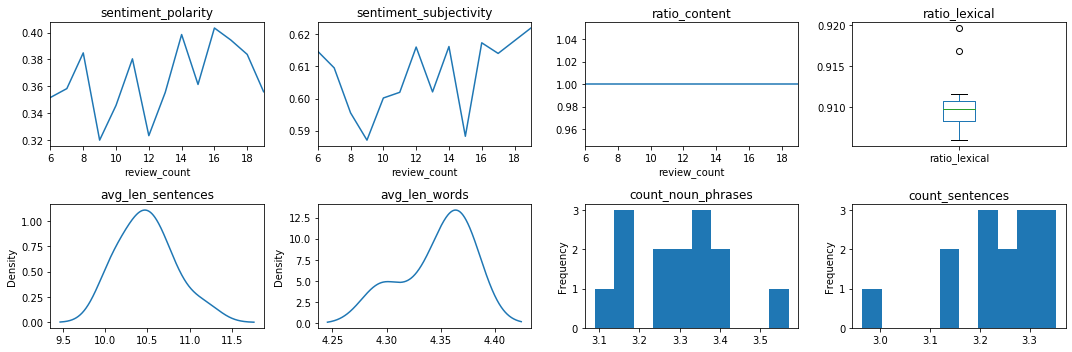

In [123]:
get_review_plots(df_g_rc)

### EDA - Review Positivity

In [9]:
users.iloc[:,[1,-1]]

,user_id,perc_of_positive
0,PKP36ulpM46aufDKUJvRhw,100.0
1,4m3kOoAlpqdSZZ_hr5f0Xg,100.0
2,z7vamcUdw3PNB222Zjw-Zw,25.0
3,lyzHnDnL7ftTExMU8_cEjw,100.0
4,a977PJaMaSRTYTaTQDZAUw,100.0
...,...,...
166776,NflUTP65orGjkramR-K59Q,NaN
166777,8Facu6ZwPI48Z7XBl1korg,0.0
166778,SB9W1AIQ2EWBdZ5wYixU7A,NaN
166779,vyK8txmse-HVk7hAKCvuMQ,NaN


In [10]:
df = pd.merge(reviews, users.iloc[:,[1,-1]], how='left', on='user_id')
df.shape

(1245408, 25)

In [11]:
df_g_rc = df.groupby(by=['perc_of_positive']).mean()
df_g_rc.sort_index(axis=0, inplace=True, ascending=True)
df_g_rc.sample(2)

,_id,stars,useful,funny,cool,_id,sentiment_polarity,sentiment_subjectivity,ratio_content,ratio_lexical,avg_len_sentences,avg_len_words,count_noun_phrases,count_words,count_sentences
perc_of_positive,,,,,,,,,,,,,,,
58.0,2.935778e+06,3.500000,0.083333,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88.0,3.411153e+06,4.466495,0.291237,0.059278,0.127577,61478.636364,0.340511,0.677656,1.0,0.87951,10.306061,4.333681,2.636364,26.363636,3.272727


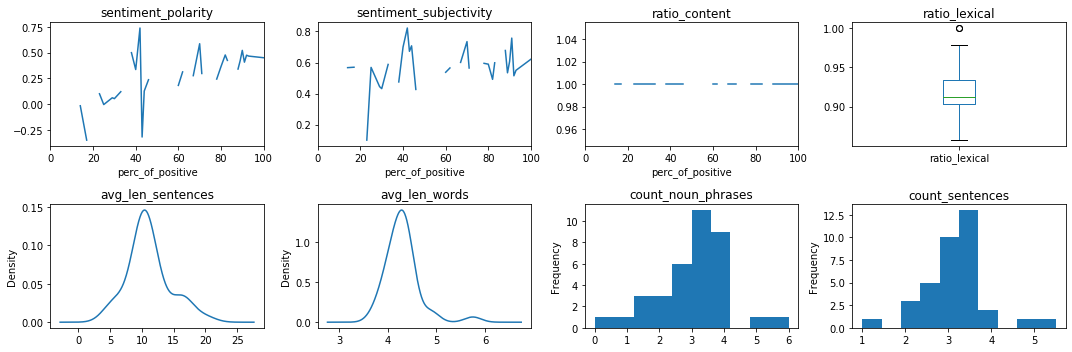

In [13]:
queries.get_review_plots(df_g_rc)

### EDA - Average Star Rating

In [14]:
df = pd.merge(reviews, users.iloc[:,[1,11]], how='left', on='user_id')
df.shape

(1245408, 25)

In [15]:
df_g_rc = df.groupby(by=['average_stars']).mean()
df_g_rc.sort_index(axis=0, inplace=True, ascending=True)
df_g_rc.sample(2)

,_id,stars,useful,funny,cool,_id,sentiment_polarity,sentiment_subjectivity,ratio_content,ratio_lexical,avg_len_sentences,avg_len_words,count_noun_phrases,count_words,count_sentences
average_stars,,,,,,,,,,,,,,,
1.57,3.476104e+06,1.903084,0.374449,0.136564,0.057269,11390.500000,-0.137500,0.765278,1.0,0.922368,9.500000,4.064474,3.500000,19.500000,2.500000
4.22,3.330333e+06,4.458716,0.299224,0.086803,0.136203,55681.384615,0.351494,0.593299,1.0,0.919999,11.535256,4.309129,2.961538,26.461538,3.038462


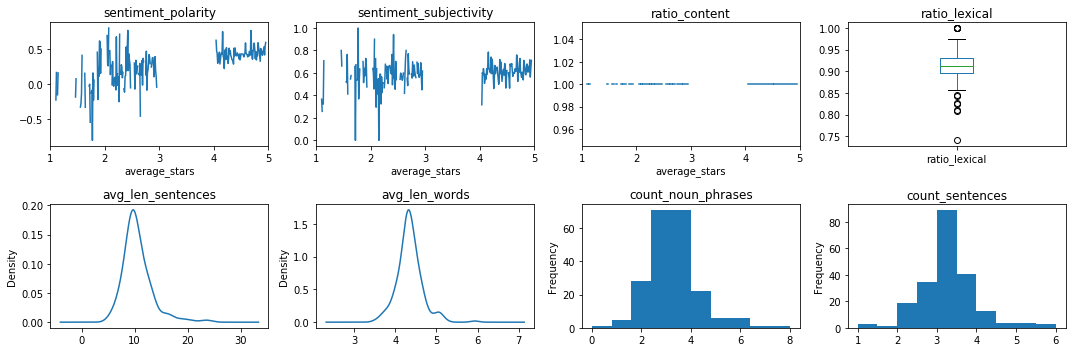

In [18]:
queries.get_review_plots(df_g_rc)

## Data Preprocessing

In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

columns = ['stars',
       'useful', 'funny', 'cool',
       'sentiment_polarity', 'sentiment_subjectivity', 'ratio_content',
       'ratio_lexical', 'avg_len_sentences', 'avg_len_words',
       'count_noun_phrases', 'count_words', 'count_sentences']

df = reviews[columns]

scaler = MinMaxScaler()
X_transformed = scaler.fit_transform(df)

X_transformed.shape

(1245408, 13)

In [82]:
X = pd.DataFrame(data=X_transformed, columns=columns)
X.fillna(value=0, inplace=True)
X.shape

(1245408, 13)

In [83]:
X.sample(2)

,stars,useful,funny,cool,sentiment_polarity,sentiment_subjectivity,ratio_content,ratio_lexical,avg_len_sentences,avg_len_words,count_noun_phrases,count_words,count_sentences
814900,0.50,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122814,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=1000, p=1, contamination='auto', metric='manhattan')
y_pred = lof.fit_predict(Xs.sample(50000))

In [ ]:
scores = lof.negative_outlier_factor_
-scores

In [ ]:
df['lof_scores'] = -scores
df['lof_labels'] = y_pred